<a href="https://colab.research.google.com/github/AristiPap/Amazon_Rainforest/blob/main/DataLoading_ARF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/siskaj/planet-amazon-deforestation.git

Cloning into 'planet-amazon-deforestation'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


In [2]:
import sys

sys.path.append('/content/planet-amazon-deforestation/src')
sys.path.append('/content/planet-amazon-deforestation/tests')



In [3]:
!pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 7.3 MB/s eta 0:00:00


In [4]:
import tf_slim as slim

In [17]:
import os
import cv2 as cv
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import data_helper


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
#paths
train_path = '/content/train_v2.csv'
test_path = '/content/test_v2_file_mapping.csv'
sample_path = '/content/sample_submission_v2.csv'

In [27]:
labels_tr_df = pd.read_csv(train_path)
labels_tr_df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [26]:
labels_tst_df = pd.read_csv(test_path)
labels_tst_df.head()

old             new
0   file_4158.tif  file_18830.tif
1   file_1668.tif  file_19164.tif
2   file_2411.tif  file_15749.tif
3  file_16047.tif   file_7531.tif
4   file_1271.tif  file_18347.tif

In [28]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_tr_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))
images_title = [labels_tr_df[labels_tr_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg'  for i, label in enumerate(labels_set)]

There is 17 unique labels including {'primary', 'agriculture', 'habitation', 'clear', 'artisinal_mine', 'cloudy', 'selective_logging', 'bare_ground', 'water', 'blooming', 'slash_burn', 'partly_cloudy', 'road', 'blow_down', 'haze', 'cultivation', 'conventional_mine'}


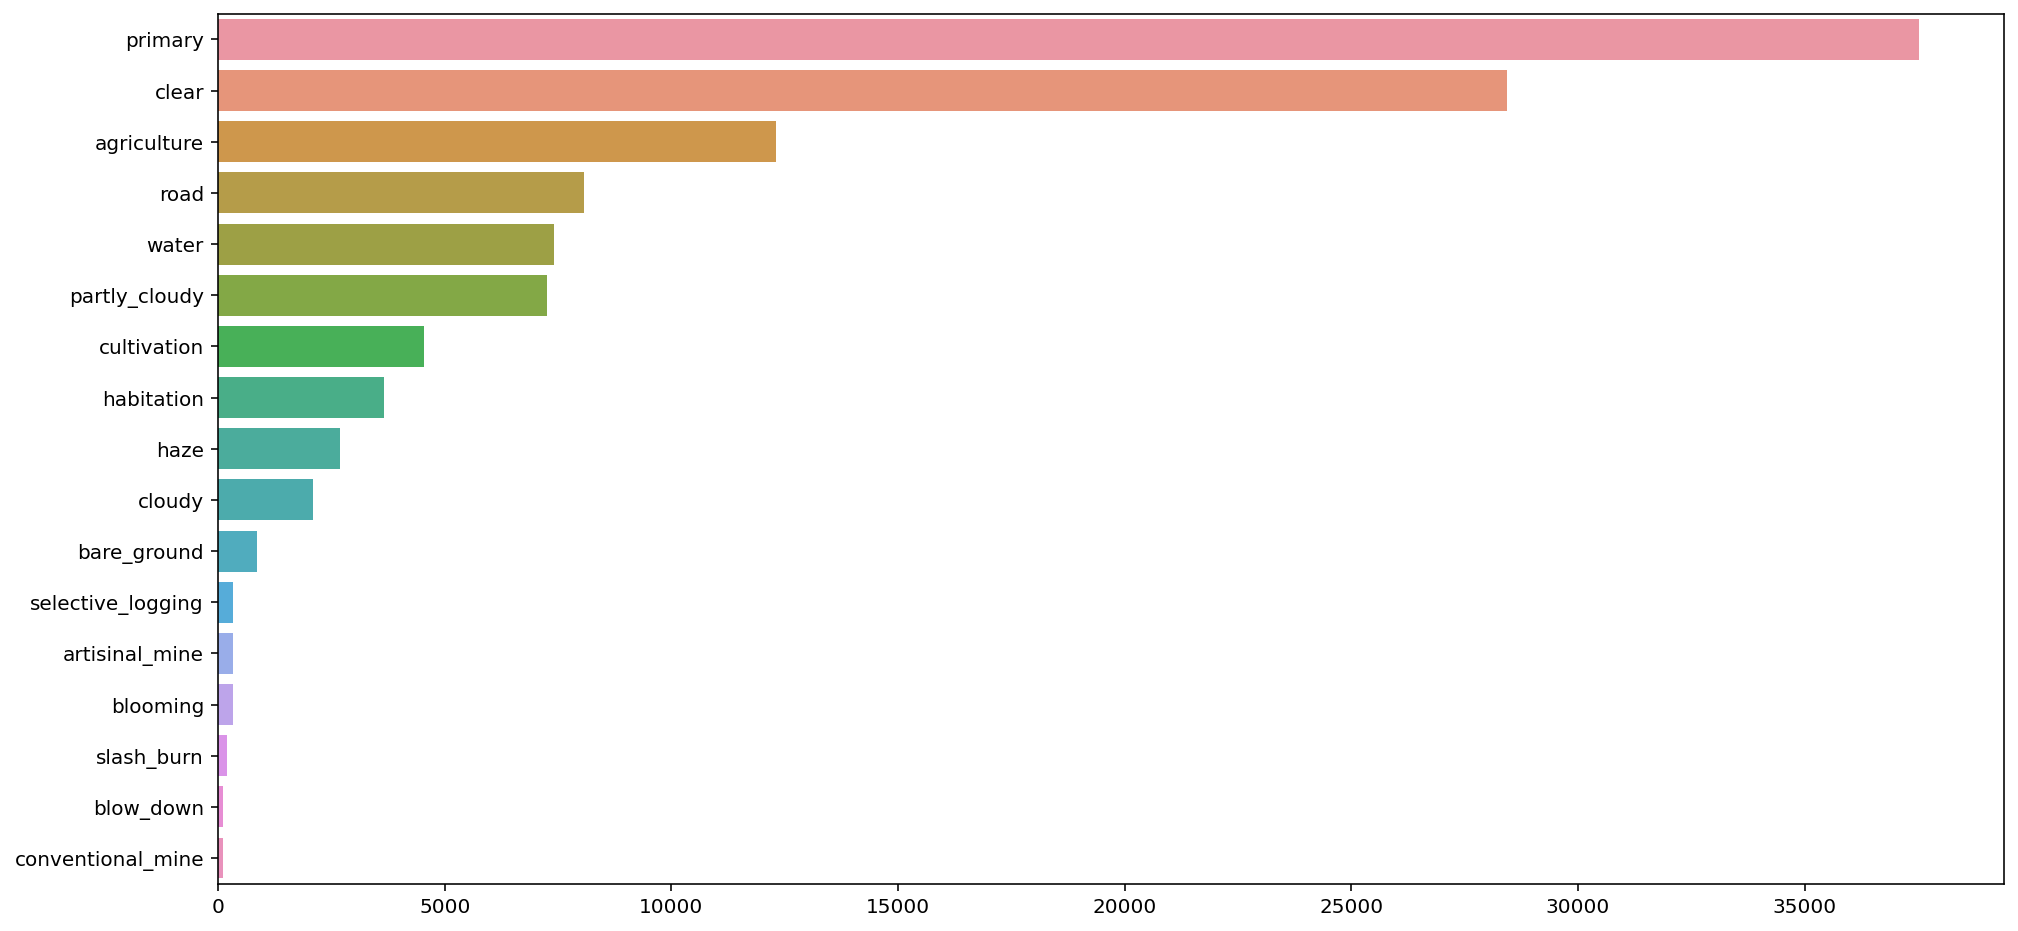

In [29]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() 
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [30]:
img_resize = (74, 74)  # nova velikost potrebna pro XCeption model
validation_split_size = 0.2
epochs = 20
batch_size = 128